# Computing gradient and divergence

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import trispectral as ts

## 1. Gradient of a scalar field

### 1.1 2D Cartesian case

Consider a 2D function $f(x, y) = x e^{-\left( x^2 + y^2 \right)}$. Its gradient is given by:

$\nabla f = \left( e^{-\left( x^2 + y^2 \right)} - 2xf \right) \boldsymbol{1}_x - 2yf \boldsymbol{1}_y$.

In the following cells we compute the gradient numerically using `trispectral`.

In [2]:
nx = ny = 41

grid = ts.Grid.from_bounds(
    [-2., 2., nx], [-2., 2., ny], discs=["chebyshev"] * 2
)
x, y = grid

`ts.gradient_operator(grid)` will return a matrix of size $3N\times N$ that can directly act on a function defined on the given grid. We then extract the $x$ and $y$ components of the resulting vector.

In [3]:
f = x * np.exp(-x**2 - y**2)

g = ts.gradient_operator(grid) @ f

gx, gy = g[: nx * ny], g[nx * ny :]

Make sure that analytical and numerical gradient fields coincide.

In [8]:
assert np.allclose(gx - np.exp(-x**2 - y**2) + 2 * x * f, 0)
assert np.allclose(gy + 2 * y * f, 0)

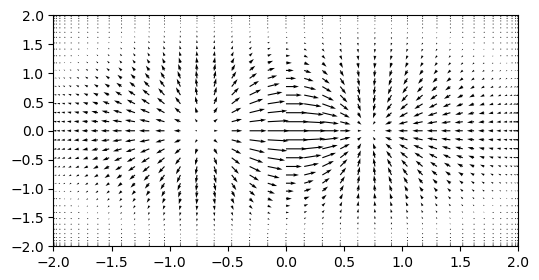

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.quiver(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    gx.reshape(nx, ny, order="F"),
    gy.reshape(nx, ny, order="F"),
    scale=20,
);

### 1.2 3D Cartesian case

Consider now a 3D function $f\left( x, y, z \right) = 2x + 3y^2 - \sin z$. Its gradient is given as follows:

$\nabla f = 2\boldsymbol{1}_x + 6y\boldsymbol{1}_y - \cos z\boldsymbol{1}_z$.

Let us compute it.

In [3]:
nx = ny = nz = 31

grid = ts.Grid.from_bounds(
    [0., 1., nx], [-1., 1., ny], [-np.pi, np.pi, nz], discs=3 * ["chebyshev"]
)
x, y, z = grid

In [4]:
f = 2 * x + 3 * y**2 - np.sin(z)

g = ts.gradient_operator(grid) @ f

In [5]:
gx, gy, gz = (
    g[: nx * ny * nz],
    g[nx * ny * nz : 2 * nx * ny * nz],
    g[2 * nx * ny * nz :],
)

Verify that the numerical values coincide with the analytical ones.

In [7]:
assert np.allclose(gx - np.full_like(x, 2.), 0)
assert np.allclose(gy - 6 * y, 0)
assert np.allclose(gz + np.cos(z), 0)

### 1.3 3D Cartesian case with homogeneous directions

Now we consider a 3D domain with two homogeneous directions $x$ and $z$, along which we assume harmonic-wave dependence, i.e.,

$f\left( x, y, z \right) = \hat{f}\left( y \right)e^{i\alpha x + i\beta z}$,

where $\alpha$ and $\beta$ are the $x$ and $z$ components of the wavevector $\boldsymbol{k}$. The gradient of $f$ is given by:

$\nabla f = e^{i\alpha x + i\beta z} \left( i\alpha \hat{f}\boldsymbol{1}_x + \hat{f}'\boldsymbol{1}_y + i\beta \hat{f}\boldsymbol{1}_z \right)$.

Consequently, in this case we can reduce our computations to a single $y$ dimension.

First, we define the wavevector to pass to `ts.gradient_operator`. In the case of Cartesian geometry, the order in which components are defined does not matter. 

In [12]:
alpha = 1.
beta = 2.
wavevector = alpha, [0, None], beta

The wavevector is always three-dimensional. Elements corresponding to inhomogeneous directions must take form of a 1D array-like containing two elements: the index of the respective axis of the grid and `None`. For instance, in the case of a single homogeneous direction $x$, and assuming that the grid is defined such that

`y, z = grid[0], grid[1]`,

the wavevector takes the following form:

`wavevector = alpha, [0, None], [1, None]`,

indicating that directions $y$ and $z$ are inhomogeneous.

In [13]:
ny = 41

grid = ts.Grid.from_bounds([-1., 1., ny], discs=["chebyshev"])
y = grid[0]

Clearly, in this case, $\hat{g}$ does not represent the gradient of the 1D function $\hat{f}$, but the incomplete gradient of the 3D function $f$. However, the value of $\nabla f$ can be trivially recovered from $\hat{g}$ for any $x$ and $z$.

In [14]:
fhat = 1 - y**2

ghat = ts.gradient_operator(grid, wavevector=wavevector) @ fhat

In [15]:
gx, gy, gz = ghat[: ny], ghat[ny : 2 * ny], ghat[2 * ny :]

In [16]:
assert np.allclose(gx - 1j * alpha * f, 0)
assert np.allclose(gy + 2 * y, 0)
assert np.allclose(gz - 1j * beta * f, 0)

## 2. Divergence of a vector field

### 2.1 3D Cartesian case

In [2]:
nx = ny = nz = 31

grid = ts.Grid.from_bounds(
    [0., 2., nx], [0., 2., ny], [-1., 1., nz], discs=3 * ["chebyshev"]
)
x, y, z = grid

In [8]:
u = np.concatenate([-y, x * y, z])

d = ts.divergence_operator(grid) @ u

In [9]:
assert np.allclose(d - x - np.ones_like(x), 0)